##  Analysis of Toronto Bikeshare ridership 


 *Phil Piltch*
 *September 4, 2019*

##### Introduction

The City of Toronto has a bike share system that allows users to use bikes for short distance trip. The bikes are available at docking stations located throughout the city. Each bicycle is locked within a dock and the rider must enter a pass code or membership key to unlock the bike. At the end of the trip, the rider then put the bike in an empty dock at a docking station. A base fee is charged for up to 30 minutes of use, with extra charges for longer trips.  Many use the bikes as part of their commute to work, or to run errands. 

In this project I analyzed the trip characteristics and also used Autoreggression to try to predict trip demand at a few of the stations. Included are some visualizations of trip volume and trending over time. For one of the visualizations I created a Tableau worksheet showing stations with most trips and those with least trips, incorporating location data from a source external to the data from the City.


This is the <a href = "https://bikesharetoronto.com/">link</a> to the Toronto Bike Share website.



In [1]:
# set up environment 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from dateutil import parser

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


##### Loading ride data from the City of Toronto

Data files are from the city's open data portal. This is the <a href="https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/">link</a> to the datasets

In [2]:
# load data to a set of pandas DataFrames

bikeshare2016Q4 = pd.read_excel('data/BikeshareRidership-2016Q4.xlsx',)
bikeshare2017Q1 = pd.read_csv('data/BikeshareRidership-2017Q1.csv')
bikeshare2017Q2 = pd.read_csv('data/BikeshareRidership-2017Q2.csv')
bikeshare2017Q3 = pd.read_csv('data/BikeshareRidership-2017Q3.csv')
bikeshare2017Q4 = pd.read_csv('data/BikeshareRidership-2017Q4.csv')

##### Preprocessing and analyzing ride data 

In [3]:
# Displaying columns for each file to check if they are the same.

print("2016 Q4",bikeshare2016Q4.columns)
print("2017 Q1",bikeshare2017Q1.columns)
print("2017 Q2",bikeshare2017Q2.columns)
print("2017 Q3",bikeshare2017Q3.columns)
print("2017 Q4",bikeshare2017Q4.columns)

2016 Q4 Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_name', 'to_station_name', 'user_type'],
      dtype='object')
2017 Q1 Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type'],
      dtype='object')
2017 Q2 Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type'],
      dtype='object')
2017 Q3 Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_name', 'to_station_name', 'user_type'],
      dtype='object')
2017 Q4 Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_name', 'to_station_name', 'user_type'],
      dtype='object')


The common columns for all files are: trip_id, trip_start_time, trip_stop_time, trip_duration_seconds, from_station_name, to_station_name, user_type. For files 2017Q1 and 2017Q2 there are the additional columns, from_station_id, to_station_id. 

In [4]:
# checking that there are no missing values

print("2016 Q4")
print(bikeshare2016Q4.isna().sum())
print("2017 Q1")
print(bikeshare2017Q1.isna().sum())
print("2017 Q2")
print(bikeshare2017Q2.isna().sum())
print("2017 Q3")
print(bikeshare2017Q3.isna().sum())
print("2017 Q4")
print(bikeshare2017Q4.isna().sum())

2016 Q4
trip_id                  0
trip_start_time          0
trip_stop_time           0
trip_duration_seconds    0
from_station_name        2
to_station_name          2
user_type                0
dtype: int64
2017 Q1
trip_id                  0
trip_start_time          0
trip_stop_time           0
trip_duration_seconds    0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
user_type                0
dtype: int64
2017 Q2
trip_id                  0
trip_start_time          0
trip_stop_time           0
trip_duration_seconds    0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
user_type                0
dtype: int64
2017 Q3
trip_id                  0
trip_start_time          0
trip_stop_time           0
trip_duration_seconds    0
from_station_name        0
to_station_name          0
user_type                0
dtype: int64
2017 Q4
trip_id                  0
trip_start_time  

In [5]:
# keeping records where the were nulls for future ref
tripswithnull=bikeshare2016Q4[pd.isnull(bikeshare2016Q4).any(axis=1)]
print("rows with NaN values: ")
tripswithnull

rows with NaN values: 


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
159,462477,2016-01-10 00:54:00,2016-01-10 01:12:00,1057,Church St / Alexander St,NaN,Member
1995,464586,2016-01-10 22:20:00,2016-01-10 22:40:00,1226,NaN,King St W / Stafford St,Member
3397,466039,2016-02-10 08:27:00,2016-02-10 08:32:00,324,Simcoe St / Wellington St W,NaN,Casual
3512,466166,2016-02-10 11:15:00,2016-02-10 11:23:00,469,NaN,Union Station,Casual


In [6]:
# dropping the records with NaN values and confirming data is now clean
bikeshare2016Q4.dropna(axis=0,inplace=True)
bikeshare2016Q4.isna().sum()

trip_id                  0
trip_start_time          0
trip_stop_time           0
trip_duration_seconds    0
from_station_name        0
to_station_name          0
user_type                0
dtype: int64

Since only 2017Q1 and 2017Q2 have to_station_id, from_station_id, we will drop these columns since we can use the station name columns to measure trip numbers and return trip numbers (trips starting and ended at the same station)

In [7]:
# dropping columns "from_station_id" and "to_station_id" from bikeshare2017Q1 and bikestation_Q2 
# as they are not in all files

bikeshare2017Q1.drop(['from_station_id','to_station_id'],axis=1,inplace=True)
bikeshare2017Q2.drop(['from_station_id','to_station_id'],axis=1,inplace=True)
print(bikeshare2017Q1.head(5))
print(bikeshare2017Q2.head(5))

   trip_id trip_start_time trip_stop_time  trip_duration_seconds  \
0   712382   1/1/2017 0:00  1/1/2017 0:03                    223   
1   712383   1/1/2017 0:00  1/1/2017 0:05                    279   
2   712384   1/1/2017 0:05  1/1/2017 0:29                   1394   
3   712385   1/1/2017 0:07  1/1/2017 0:21                    826   
4   712386   1/1/2017 0:08  1/1/2017 0:12                    279   

                   from_station_name                to_station_name user_type  
0  Wellesley St E / Yonge St Green P           Church St  / Wood St    Member  
1           Kendal Ave / Bernard Ave        Bathurst Subway Station    Member  
2       Parliament St / Aberdeen Ave      College St W / Markham St    Member  
3                 College Park South        King St W / Spadina Ave    Member  
4              McGill St / Church St  University Ave / Gerrard St W    Member  
   trip_id trip_start_time trip_stop_time  trip_duration_seconds  \
0   868665   1/4/2017 0:01  1/4/2017 0:06  

In [8]:
# merging all the files into one file
bikeshare_all = bikeshare2016Q4.append(bikeshare2017Q1,ignore_index=True)
bikeshare_all = bikeshare_all.append(bikeshare2017Q2,ignore_index=True)
bikeshare_all = bikeshare_all.append(bikeshare2017Q3,ignore_index=True)
bikeshare_all = bikeshare_all.append(bikeshare2017Q4,ignore_index=True)
bikeshare_all.tail(5)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
1709929,2383642,12/31/17 23:46:27,12/31/17 23:46:53,26,Bloor St / Brunswick Ave,Bloor St / Brunswick Ave,Casual
1709930,2383643,12/31/17 23:47:13,1/01/18 00:11:40,1467,Bloor St / Brunswick Ave,HTO Park (Queens Quay W),Casual
1709931,2383644,12/31/17 23:47:40,12/31/17 23:57:49,609,Kendal Ave / Spadina Rd,Augusta Ave / Denison Sq,Member
1709932,2383645,12/31/17 23:49:08,12/31/17 23:49:34,26,Phoebe St / Spadina Ave,Phoebe St / Spadina Ave,Member
1709933,2383646,12/31/17 23:49:41,12/31/17 23:57:41,480,Phoebe St / Spadina Ave,Simcoe St / Queen St W,Member


In [9]:
# create columns for hour of trip, day of week and date of trip

bikeshare_all['trip_hour'] = pd.to_datetime(bikeshare_all['trip_start_time']).dt.hour

bikeshare_all['trip_day_of_wk'] = pd.to_datetime(bikeshare_all['trip_start_time']).dt.dayofweek

bikeshare_all['trip_date'] = pd.to_datetime(bikeshare_all['trip_start_time']).dt.date

In [10]:
bikeshare_all.head(4)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,trip_hour,trip_day_of_wk,trip_date
0,462305,2016-01-10 00:00:00,2016-01-10 00:07:00,394,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual,0,6,2016-01-10
1,462306,2016-01-10 00:00:00,2016-01-10 00:09:00,533,Sherbourne St / Wellesley St,Edward St / Yonge St,Member,0,6,2016-01-10
2,462307,2016-01-10 00:00:00,2016-01-10 00:07:00,383,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual,0,6,2016-01-10
3,462308,2016-01-10 00:01:00,2016-01-10 00:27:00,1557,Cherry St / Distillery Ln,Fort York Blvd / Capreol Crt,Casual,0,6,2016-01-10


In [11]:
trips_by_daywk = bikeshare_all.groupby(['trip_day_of_wk']).agg('count')
trips_by_daywk.head(7)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,trip_hour,trip_date
trip_day_of_wk,,,,,,,,,
0,247748,247748,247748,247748,247748,247748,247748,247748,247748
1,262427,262427,262427,262427,262427,262427,262427,262427,262427
2,279661,279661,279661,279661,279661,279660,279661,279661,279661
3,251491,251491,251491,251491,251491,251491,251491,251491,251491
4,251858,251858,251858,251858,251858,251858,251858,251858,251858
5,209726,209726,209726,209726,209726,209726,209726,209726,209726
6,207023,207023,207023,207023,207023,207023,207023,207023,207023


In [12]:
# create file with total trips for each station
trips_perstn = bikeshare_all.groupby(['from_station_name']).agg('count')
trips_perstn.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,to_station_name,user_type,trip_hour,trip_day_of_wk,trip_date
from_station_name,,,,,,,,,
111 Bond St (North of Dundas St E) - SMART,718,718,718,718,718,718,718,718,718
161 Bleecker St (South of Wellesley),4405,4405,4405,4405,4405,4405,4405,4405,4405
25 York St (ACC/Union Station South),8692,8692,8692,8692,8692,8692,8692,8692,8692
424 Wellington St W,2833,2833,2833,2833,2833,2833,2833,2833,2833
424 Wellington St. W,5169,5169,5169,5169,5169,5169,5169,5169,5169


In [13]:
# 1. Create file with just the trip date, trip starting point and hour of day grouped by trip date and station
trips_by_date  =  bikeshare_all[['trip_date','from_station_name','trip_hour']].groupby(['trip_date','from_station_name']).agg('count')

# 2. Unstack and remove NaN values
trips_by_date = trips_by_date.unstack(level = 1)

trips_by_date = trips_by_date.fillna(0)

# 3. Flatten row and colunm indecies 
trips_by_date.columns.get_level_values(1)

trips_by_date.columns = [col[1] for col in trips_by_date.columns.values]


# 4. Change row index to date-time for time series analysis
trips_by_date.index.astype('datetime64[ns]')

# 5. Store columns for plotting purposes
trips_by_date_col = trips_by_date.columns

In [14]:
# find all trips with from station the same as to station (round trips)
bikeshare_round = pd.DataFrame(columns = bikeshare_all.columns)

for i in range(len(bikeshare_all)):
    if bikeshare_all.iloc[i,4] == bikeshare_all.iloc[i,5]:
        bikeshare_round = bikeshare_round.append(bikeshare_all.iloc[i,:])
        
bikeshare_round.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,trip_hour,trip_day_of_wk,trip_date
45,462353,2016-01-10 00:16:00,2016-01-10 01:02:00,2747,King St W / Bay St (East Side),King St W / Bay St (East Side),Casual,0,6,2016-01-10
91,462401,2016-01-10 00:31:00,2016-01-10 00:44:00,791,Simcoe St / Dundas St W,Simcoe St / Dundas St W,Member,0,6,2016-01-10
104,462414,2016-01-10 00:35:00,2016-01-10 00:44:00,574,Bremner Blvd / Spadina Ave,Bremner Blvd / Spadina Ave,Member,0,6,2016-01-10
108,462418,2016-01-10 00:36:00,2016-01-10 00:53:00,1047,Exhibition GO (Atlantic Ave),Exhibition GO (Atlantic Ave),Member,0,6,2016-01-10
118,462432,2016-01-10 00:39:00,2016-01-10 01:16:00,2201,Bay St / Albert St,Bay St / Albert St,Casual,0,6,2016-01-10


In [15]:
# We will now see which station has the most total trips and which has the least. 

trip_counts = trips_perstn['trip_id']
stations_most = trip_counts.sort_values(ascending=False).head(5)
stations_least = trip_counts.sort_values(ascending=False).tail(7)

# export to CSV files to put in Tableau where we can visualize locations on a map
stations_most.to_csv('stations_most.csv',header=True)
stations_least.to_csv('stations_least.csv',header=True)

In [16]:
# Get the total round trips per station

round_cnts = bikeshare_round.groupby(['from_station_name']).agg('count')
round_cnts.head()


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,to_station_name,user_type,trip_hour,trip_day_of_wk,trip_date
from_station_name,,,,,,,,,
111 Bond St (North of Dundas St E) - SMART,18,18,18,18,18,18,18,18,18
161 Bleecker St (South of Wellesley),152,152,152,152,152,152,152,152,152
25 York St (ACC/Union Station South),226,226,226,226,226,226,226,226,226
424 Wellington St W,157,157,157,157,157,157,157,157,157
424 Wellington St. W,90,90,90,90,90,90,90,90,90


In [19]:
# Get the stations with the most round trips
round_most=round_cnts['trip_id'].sort_values(ascending=False).head(5)

# export to CSV files to put in Tableau where we can visualize locations on a map
round_most.to_csv('most_round.csv',header=True)


In [20]:
# Stations with most trips - will be used for autoregression model
station_most_trips = trips_by_date['Union Station']

# Station with least trips
station_least_trips = trips_by_date['Victoria Park Subway Station - SMART']

# Station with most round trips

station_most_round = trips_by_date['Ontario Place Blvd / Remembrance Dr']

### Visualizing the Data 

Here are some bar graphs showing trip volume for various stations and also how overall trip volume is distributed for various days of the week

<Figure size 1440x1440 with 0 Axes>

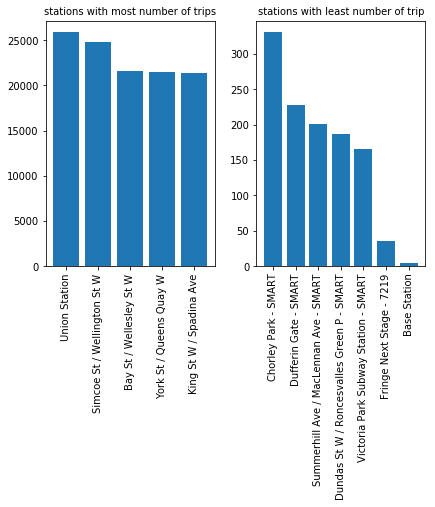

<Figure size 1440x1440 with 0 Axes>

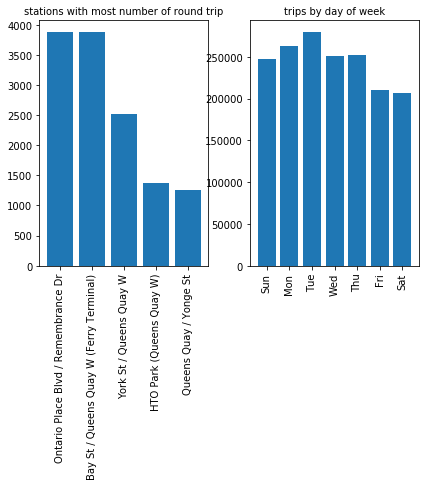

In [21]:
day_of_week = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

plt.figure(figsize=(20,20))
plt.subplots(1,2)
plt.tight_layout()

plt.subplot(1,2,1)
plt.title("stations with most number of trips", fontsize = 10)
plt.bar(stations_most.index,stations_most.values)
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.title("stations with least number of trip", fontsize = 10)
plt.bar(stations_least.index,stations_least.values)
plt.xticks(rotation='vertical')

plt.show()

plt.figure(figsize=(20,20))
plt.subplots(1,2)
plt.tight_layout()

plt.subplot(1,2,1)
plt.title("stations with most number of round trip", fontsize = 10)
plt.bar(round_most.index,round_most.values)
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.title("trips by day of week", fontsize = 10)
plt.bar(day_of_week,trips_by_daywk['trip_id'])
plt.xticks(rotation='vertical')


plt.show()


#### Visualization through Tableau

Bike stations with the most trips and with the least trips plotted geographically. Extracted files had longitude and latitude added from an external website and then merged to plot in Tableau.

In [23]:
%%HTML 
<div class='tableauPlaceholder' id='viz1567385965637' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;Toronto_bikeshare&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Toronto_bikeshare&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;Toronto_bikeshare&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1567385965637');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

##### Plot over time

These are time-base plots for the station with most trip, the station with least trips and the one with most round trips. 

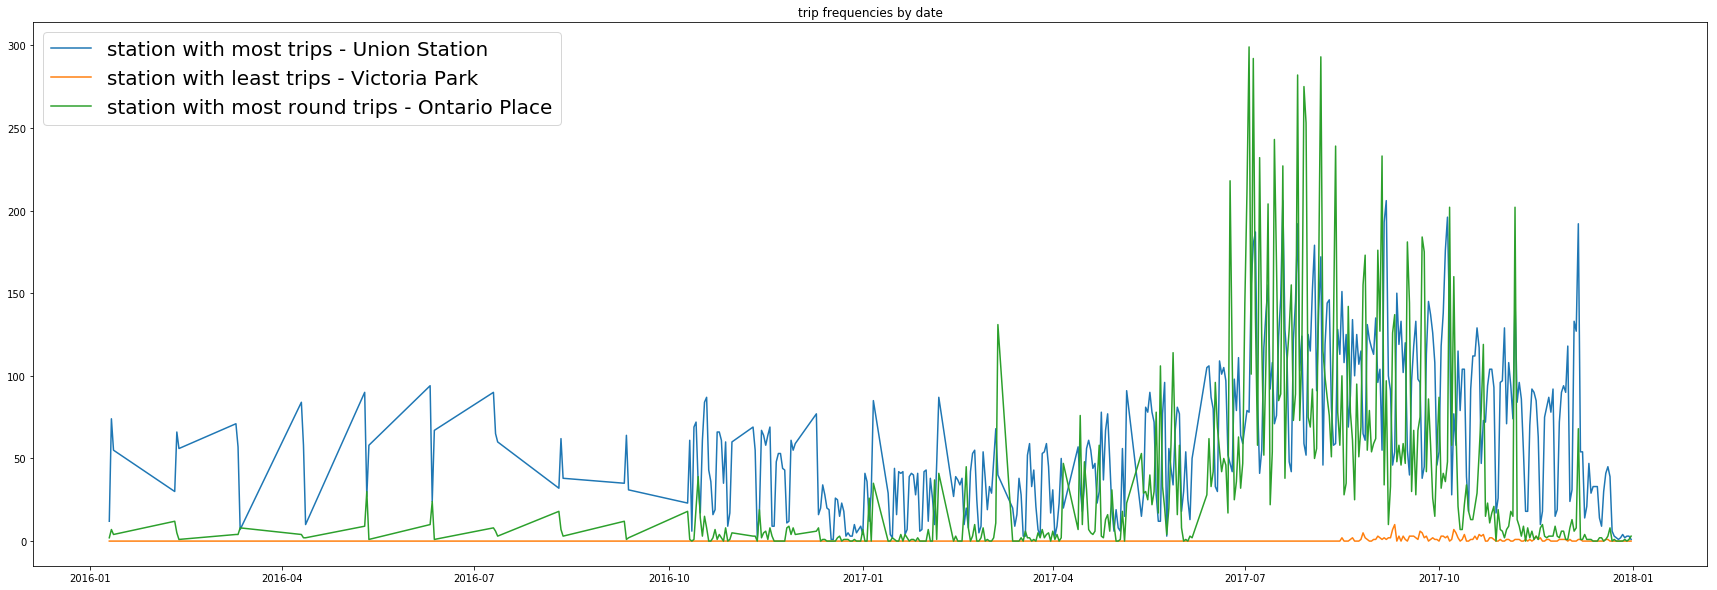

In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(30,10))
plt.title("trip frequencies by date")
plt.rcParams.update({'font.size':20})
plt.plot(station_most_trips.index,station_most_trips, label = "station with most trips - Union Station")
plt.plot(station_least_trips.index,station_least_trips, label = "station with least trips - Victoria Park")
plt.plot(station_most_round.index,station_most_round, label = "station with most round trips - Ontario Place" )
plt.legend(loc=2, prop={'size': 20})
plt.show()

###  Autoregression models on the data for three stations

Reference: <a href = "https://machinelearningmastery.com/make-manual-predictions-arima-models-python/">How to Make Manual Predictions for ARIMA Models with Python</a>

For this model, I split the time period into a train and test set, with the test set containing the last 14 days of the data time period. 

In [25]:
# Run an Autoregression Moving Average model for selected stations 
# doing a manul prediction. 


def predict(coef, history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat


# Station with most trips
print('Union Station')
X = station_most_trips.values
size = len(X) - 14
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit(trend='nc', disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	yhat = predict(ar_coef, history) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('>predicted=%.1f, expected=%.1f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
unionst_obs = test
unionst_pred = predictions
print('Test RMSE: %.3f' % rmse)

print("---------")

# Station with least trips
print('Victoria Park Subway Station - SMART')
X = station_least_trips.values
size = len(X) - 14
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit(trend='nc', disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	yhat = predict(ar_coef, history) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('>predicted=%.1f, expected=%.1f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
vicpark_obs = test
vicpark_pred = predictions
print('Test RMSE: %.3f' % rmse)


print("----------")

# Station with most round trips
print('Ontario Place Blvd / Remembrance Dr')
X = station_most_round.values
size = len(X) - 14
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit(trend='nc', disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	yhat = predict(ar_coef, history) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('>predicted=%.1f, expected=%.1f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
ontplce_obs = test
ontplce_pred = predictions
print('Test RMSE: %.3f' % rmse)

Union Station
>predicted=45.3, expected=30.0
>predicted=43.4, expected=41.0
>predicted=43.0, expected=45.0
>predicted=43.2, expected=39.0
>predicted=42.6, expected=6.0
>predicted=38.2, expected=3.0
>predicted=33.9, expected=2.0
>predicted=29.8, expected=1.0
>predicted=26.0, expected=2.0
>predicted=22.7, expected=4.0
>predicted=20.2, expected=2.0
>predicted=17.7, expected=3.0
>predicted=15.6, expected=3.0
>predicted=13.9, expected=1.0
Test RMSE: 21.521
---------
Victoria Park Subway Station - SMART
>predicted=0.1, expected=0.0
>predicted=0.1, expected=1.0
>predicted=0.2, expected=1.0
>predicted=0.3, expected=0.0
>predicted=0.3, expected=0.0
>predicted=0.2, expected=0.0
>predicted=0.2, expected=0.0
>predicted=0.2, expected=0.0
>predicted=0.1, expected=0.0
>predicted=0.1, expected=0.0
>predicted=0.1, expected=0.0
>predicted=0.1, expected=0.0
>predicted=0.1, expected=0.0
>predicted=0.1, expected=0.0
Test RMSE: 0.360
----------
Ontario Place Blvd / Remembrance Dr
>predicted=3.8, expected=0.

##### Plot  of predicted ride volume for the last 14 days of the 2016-2017 time period.

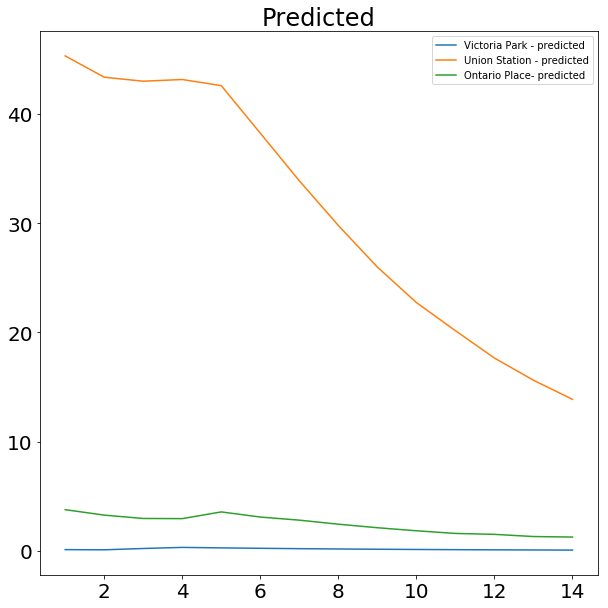

In [26]:
xvalues = range(1,15)

plt.figure(figsize= (10,10))
plt.title('Predicted')
plt.plot(xvalues,vicpark_pred,label='Victoria Park - predicted')
plt.plot(xvalues,unionst_pred,label='Union Station - predicted')
plt.plot(xvalues,ontplce_pred,label='Ontario Place- predicted')
plt.legend(loc=1, prop={'size': 10})
plt.show()

##### Plot  of actual ride volume for the last 14 days of the 2016-2017 time period.

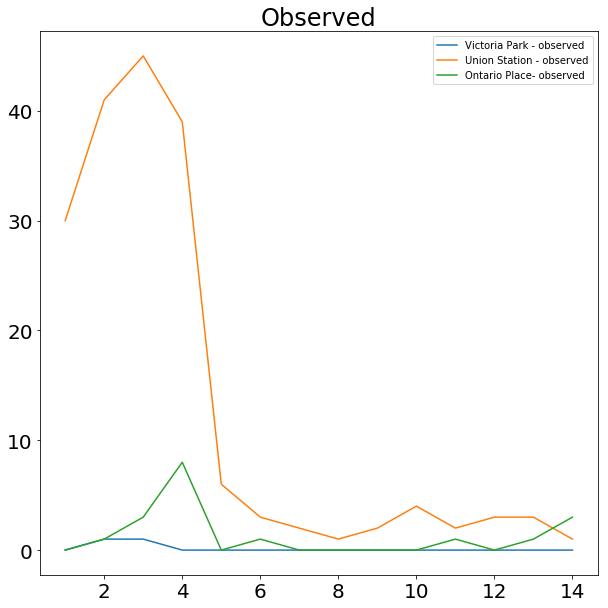

In [27]:
plt.figure(figsize= (10,10))
plt.title('Observed')
plt.plot(xvalues,vicpark_obs,label='Victoria Park - observed')
plt.plot(xvalues,unionst_obs,label='Union Station - observed')
plt.plot(xvalues,ontplce_obs,label='Ontario Place- observed')
plt.legend(loc=1, prop={'size': 10})
plt.show()

##### Observations and conclusions


Toronto's bike share system is well used. Station locations with the most trips are located in the downtown core. The stations with the least trips were located in more suburban areas. Three stations were used for auto-regression model: Union Station, which had the most number of trips; Victoria Park, which had the lowest number; Ontario Place, which had the highest number of round trips. Ride trip frequecy for two of the three select stations showed a large increase in Q3. This was likely that there were events such as the Canadian National Exhibition and Toronto International Film Festival which bring in many vistors to Toronto. Victoria Park showed no changes, likely due to its remote location where only local residents might use it. Given the higher variance in trip volume for Union Station, the model had a higher RSME and trip predictions were less accurate. 

##### Future objectives 

The data used is historical data. There is more recent data accessed through a JSON API and I will work on updating the code to pull more recent data from the open data portal and see how the system use has changed over time. As well I can see how member and nonmember use differ.

My original objective was to see if I could predict bike availability and free dock availabilty at each station for each how of the day but the data did not contain a defined target variable and from the features in the data one would have to find a way to create an implicit way to calculate availability. The original objective does relate to a real problem that the system users face and going forward I would like to explore a way to create a predictive model for this. 